In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import numpy as np
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense,LSTM,Input,SimpleRNN,GRU,Conv1D,MaxPool1D,Conv2D,MaxPool2D,Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import SGD,Adam,Adamax
from tensorflow.keras.losses import MAPE,MSE
from tensorflow.keras import losses
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MAPE,MAE,MeanAbsolutePercentageError,MeanSquaredError,RootMeanSquaredError
from datetime import datetime
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from pickle import dump,load
import joblib
import sys

def importa(archivo,nombres):
        #nombres=['tiempo','Direct','Global','Difusa','Temperatura','Humedad','Presion']
        esoru=pd.read_csv(archivo,names=nombres,skiprows=1)
        esoru.tiempo=pd.to_datetime(esoru.tiempo,format='%Y-%m-%d %H:%M:%S')
        esoru.set_index('tiempo',inplace=True)
        return (esoru)

def seasonal_pre_process(in_size,out_size,esoru,scaler,scaler2,inputs,outputs,training_step,season_size): #scaler fit is here
     #global scaler,scaler2,x_train,y_train,x_val,y_val,x_test,y_test
     set_size=in_size+out_size
     esona=esoru.interpolate(method='polynomial',order=1)
     outna=esona[output]#[0:int(144*30.98)]
     inpna=esona[inputs]#[0:int(144*30.98)]
     train_val_ratio=1#.9 #Qué porcentaje serán los datos de entrenamiento y validación 
     train_ratio=1#.8 #Qué porcentaje serán los datos de solo entrenamiento 

     arresoru=np.array(outna)
     arresoruin=np.array(inpna)
     scaler.fit(arresoruin[0:int(len(arresoruin)*train_ratio)])
     scaler2.fit(arresoru[0:int(len(arresoru)*train_ratio)])
     dump(scaler, open('02_grid_training/03_scalers/x_scalerv01.pkl','wb'))
     dump(scaler2,open('02_grid_training/03_scalers/y_scalerv01.pkl','wb'))
     pre_array=[]
     pre_arrax=[]
     arresoruin=scaler.transform(arresoruin)
     arresoru=scaler2.transform(arresoru)
     for set_step in range (0,len(arresoruin)-season_size-out_size,training_step):
         x1=arresoruin[set_step:set_step+in_size]
         pre_arrax.append(x1)
         y=arresoru[set_step+season_size:set_step+season_size+out_size]
         pre_array.append(y)
     x_array=np.stack(pre_arrax)
     y_array=np.stack(pre_array)
     #y_trainfull,x_trainfull=y_array[0:int(y_array.shape[0]*train_val_ratio)],x_array[0:int(x_array.shape[0]*train_val_ratio)]
     #y_train,x_train=y_trainfull[0:int(y_trainfull.shape[0]*train_ratio)],x_trainfull[0:int(x_trainfull.shape[0]*train_ratio)]
     #y_val,x_val=y_trainfull[int(y_trainfull.shape[0]*train_ratio):],x_trainfull[int(x_trainfull.shape[0]*train_ratio):]
     #y_test,x_test=y_array[int(y_array.shape[0]*train_val_ratio):],x_array[int(x_array.shape[0]*train_val_ratio):]
     return (scaler,scaler2,x_array,y_array)

def seasonal_pre_process2(in_size,out_size,esoru,scaler,scaler2,inputs,outputs,training_step,season_size): #when scaler is already fitted
     #global scaler,scaler2,x_train,y_train,x_val,y_val,x_test,y_test
     set_size=in_size+out_size
     esona=esoru.interpolate(method='polynomial',order=1)
     #listminhora,listadias,lista_meses=lista_maker()
     #esona=time_prep(esona,listadias,lista_meses,listminhora)
     #esona=nightzero_timeprep(esona,'nada2',save=False)
     #print(esona)
     fecha1='2019-01-01'
     fecha2='2019-01-31'
     outna=esona[outputs]#[fecha1:fecha2]
     inpna=esona[inputs]#[fecha1:fecha2]
     print(inpna)
     train_val_ratio=1#.9 #Qué porcentaje serán los datos de entrenamiento y validación 
     train_ratio=1#.8 #Qué porcentaje serán los datos de solo entrenamiento 
     
     arresoru=np.array(outna)
     arresoruin=np.array(inpna)
     #scaler.fit(arresoruin[0:int(len(arresoruin)*train_ratio)])
     #scaler2.fit(arresoru[0:int(len(arresoru)*train_ratio)])
     pre_array=[]
     pre_arrax=[]
     arresoruin=scaler.transform(arresoruin)
     arresoru=scaler2.transform(arresoru)
     for set_step in range (0,len(arresoruin)-season_size-out_size,training_step):
         x1=arresoruin[set_step:set_step+in_size]
         pre_arrax.append(x1)
         y=arresoru[set_step+season_size:set_step+season_size+out_size]
         pre_array.append(y)
     y_array,x_array=np.stack(pre_array),np.stack(pre_arrax)
     #y_trainfull,x_trainfull=y_array[0:int(y_array.shape[0]*train_val_ratio)],x_array[0:int(x_array.shape[0]*train_val_ratio)]
     #y_train,x_train=y_trainfull[0:int(y_trainfull.shape[0]*train_ratio)],x_trainfull[0:int(x_trainfull.shape[0]*train_ratio)]
     #y_val,x_val=y_trainfull[int(y_trainfull.shape[0]*train_ratio):],x_trainfull[int(x_trainfull.shape[0]*train_ratio):]
     #y_test,x_test=y_array[int(y_array.shape[0]*train_val_ratio):],x_array[int(x_array.shape[0]*train_val_ratio):]
     return (x_array,y_array)
    
def train_ann(x_train,y_train,x_val,y_val,epochs,in_size,out_size,bs):
    #global hist,run_epocs,training_time,initial_time,end_time
    initial_time=datetime.today()
    model=Sequential([
     Conv1D(filters=64,kernel_size=1,input_shape=[None,x_train.shape[2]],activation='relu'), #Kernel size era = a 3
#      MaxPool1D(pool_size=1,strides=1),
#      Conv1D(filters=128,kernel_size=3,activation='relu'),
#      MaxPool1D(pool_size=1,strides=1),
#      Conv1D(filters=256,kernel_size=3,activation='relu'),
#      MaxPool1D(pool_size=1,strides=1),
#      Conv1D(filters=128,kernel_size=3,activation='relu'),
     MaxPool1D(pool_size=1,strides=1),
     Conv1D(filters=64,kernel_size=1,activation='relu'),     #Kernel size era = a 3
     MaxPool1D(pool_size=1,strides=1),
        
#      LSTM(64,return_sequences=True),
#      LSTM(128,return_sequences=True),
#      LSTM(256,return_sequences=True),
     LSTM(128,return_sequences=True),
     LSTM(64,return_sequences=False),
     Dropout(.1),
#      Dense(out_size,activation='sigmoid'),
#      Dense(out_size,activation='sigmoid'), 
     Dense(out_size,activation='sigmoid'), 
     ])
    print('in_size:',in_size)
    print('out_size:',out_size)
    model.compile(optimizer=opt,loss=MSE)
    hist=model.fit(x=x_train,y=y_train,batch_size=bs,validation_data=(x_val,y_val),epochs=epochs,callbacks=[cb])
    model.save('02_grid_training/01_models/'+name_model+'.h5')
    print('Acabó y se guardó el entrenamiento... Guardando imagen de historial de entrenamiento' )
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.savefig('02_grid_training/02_training_figures/'+name_model+'.png')
    run_epocs=len(hist.history['loss'])
    model.summary()
    end_time=datetime.today()
    training_time=end_time-initial_time
    return (model,hist,run_epocs,training_time,initial_time,end_time)


In [8]:
archivo='../01_weather_data/02_cleaned_data/TMY_night_solar_angles.csv'
nombres1=['tiempo','Direct','Global','Difusa','Temperatura','Humedad','Presion','alturasolar','azimuth']
tmydf=importa(archivo,nombres1)
esoru=importa('../01_weather_data/02_cleaned_data/esoru_night_angles.csv',nombres1)
#**********************************************************************************************************************    
#fecha1='2019-01-01'
#fecha2='2019-12-31'
in_size=6#Tamaño entrada nada mas 
out_size=6
training_step=1
season_size=144
bs=12
#***********************************************************************************************************************
#listminhora,listadias,lista_meses=lista_maker()
output=['Global']
inputs=['Global','Direct','Temperatura','Humedad','azimuth','alturasolar']#+listminhora+listadias+lista_meses
#s=33458/(32*1)
lr=1e-5
opt=Adam(lr)
cb=EarlyStopping(patience=7,restore_best_weights=True)
scaler=MinMaxScaler()
scaler2=MinMaxScaler()
initial_epochs=2
name_model='train_seasonal_out_s_'+str(out_size)+'_lr_'+str(lr)+'_'+'in_s_'+str(in_size)+(output[0])+'_BS'+str(bs)
#**************************************************************************************************************************

batch_size: 12
train_seasonal_out_s_6_lr_1e-05_in_s_6Global_BS12

Gotten inputs starting program
                     Global  Direct  Temperatura  Humedad     azimuth  \
tiempo                                                                  
2019-01-01 00:00:00     0.0     0.0        17.85    59.02  166.773196   
2019-01-01 00:10:00     0.0     0.0        18.29    59.84  170.053742   
2019-01-01 00:20:00     0.0     0.0        17.92    60.08  173.367191   
2019-01-01 00:30:00     0.0     0.0        17.91    61.51  176.703016   
2019-01-01 00:40:00     0.0     0.0        17.94    61.41 -179.949903   
...                     ...     ...          ...      ...         ...   
2019-12-31 23:10:00     0.0     0.0        20.94    58.99  151.345160   
2019-12-31 23:20:00     0.0     0.0        21.20    58.03  154.338568   
2019-12-31 23:30:00     0.0     0.0        21.52    56.33  157.400817   
2019-12-31 23:40:00     0.0     0.0        21.67    57.35  160.527038   
2019-12-31 23:50:00     0.0

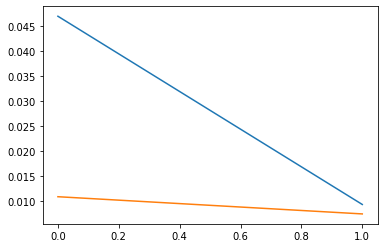

In [9]:
print('batch_size:',bs)
print(name_model+ '\n')
print('Gotten inputs starting program')   
# scaler,scaler2,x_train,y_train=pre_process(in_size,out_size,tmydf,scaler,scaler2,inputs,output,training_step)
# x_val,y_val=pre_process2(in_size,out_size,esoru,scaler,scaler2,inputs,output,training_step)
scaler,scaler2,x_train,y_train=seasonal_pre_process(in_size,out_size,tmydf,scaler,scaler2,inputs,output,training_step,season_size)
x_val,y_val=seasonal_pre_process2(in_size,out_size,esoru,scaler,scaler2,inputs,output,training_step,season_size)
# x_train = np.asarray(x_train).astype(np.float32)
# y_train = np.asarray(y_train).astype(np.float32)
print('preprocessing ended... starting training')
model,hist,run_epocs,training_time,initial_time,end_time=train_ann(x_train,y_train,x_val,y_val,initial_epochs,in_size,out_size,bs)
print('tiempo de entrenamiento: ',training_time)
print('épocas corridas: ',run_epocs)
print (name_model,training_time,run_epocs)

In [10]:
val_error=model.evaluate(x_val,y_val)
train_error=model.evaluate(x_train,y_train)
print('val_error',val_error)
print('train_error',train_error)

1607/1607 [==============================] - 5s 3ms/step - loss: 0.0081
val_error 0.007445321884006262
train_error 0.008142837323248386


In [11]:
istep=0
forward_steps=144*3
i=0
output=[]
target=[]
for step in range (istep,istep+forward_steps,out_size):
    pry=model.predict(x_val[step].reshape(1,in_size,6))
    pry=scaler2.inverse_transform(pry)
    prx=y_val[step]
    prx=scaler2.inverse_transform(prx)
    #     print(pry)
    output.append(pry)
    target.append(prx)
output=np.asarray(output,dtype='object').reshape(forward_steps,1)
target=np.asarray(target,dtype='object').reshape(forward_steps,1)


In [13]:
output=output.reshape(forward_steps)

In [14]:
def dfmetricas(impesoru,impesoru_target,model_name):
    dfrad=impesoru_target.copy()
    dfrad['prediccion']=impesoru.Global.copy()
    dfrad['minutodia']=(dfrad.index.hour*60)+dfrad.index.minute
    dfrad['me']=(dfrad.prediccion-dfrad.Global)
    dfrad['mae']=np.abs(dfrad.Global-dfrad.prediccion)
    dfmingroup=dfrad.groupby(['minutodia',pd.Grouper(freq='1H')]).mean()
    dfmindia=dfmingroup.groupby(pd.Grouper(level='minutodia',axis=0)).mean()

    dfmindia.loc[dfmindia.alturasolar<0,'mae']=np.nan
    meandiay=dfmindia.mae.mean()

    dfsamp2=dfrad.resample('D').sum()
    dfsamp=dfrad.resample('D').mean()
    #dfsamp3['rmse']=dfsamp3['mse']**.5
    dfsamp['dif_energia_wh']=dfsamp2['me']/6
    dfsamp['dif_energia_wh_mae']=dfsamp2['mae']/6
    dfsamp['energia_wh/m2']=dfsamp2['Global']/6
    dfsamp['porcentaje_mae']=(dfsamp['dif_energia_wh_mae']/dfsamp['energia_wh/m2'])*100
    dfsamp['energia_predicha_wh/m2']=dfsamp2['prediccion']/6

    # tablita=['Global','prediccion','energia_wh/m2','energia_predicha_wh/m2','dif_energia_wh','porcentaje_energia','porcentaje_mae','mae_de_día_promedio']
    tablita=['model','dif_energia_wh','porcentaje_energia','porcentaje_mae','mae_de_día_promedio']
    dfsamp3=dfsamp.resample('Y').mean()
    dfsamp3['mae_de_día_promedio']=meandiay
    dfsamp3['dif_energia_wh']=-dfsamp3['energia_wh/m2']+dfsamp3['energia_predicha_wh/m2']
    dfsamp3['porcentaje_energia']=dfsamp3['dif_energia_wh']/dfsamp3['energia_wh/m2']*100
    dfsamp3['model']=model_name
    return(dfsamp3[tablita],dfsamp,dfrad)
def seasonal_exporta(archivo,predi,istep,in_size,rango,nombres,sol_data_correction=False,save=False,archivo_nombre='imputados_corregidos.csv'): #Sustituye datos de entrada por datos predecidos
     #nombres=['tiempo','Direct','Global','Difusa','Temperatura','Humedad','Viento','Presion','WDir_Avg','Rain_Tot']
     esoru=pd.read_csv(archivo,names=nombres,skiprows=1)
     #esoru.tiempo=pd.to_datetime(esoru.tiempo,format='%Y-%m-%d %H:%M:%S')
     #esoru.set_index('tiempo',inplace=True)
     esoru.Global.iloc[istep+season_size:istep+season_size+rango]=predi.copy() #agregar nueva columna 
     esoru.tiempo=pd.to_datetime(esoru.tiempo,format='%Y-%m-%d %H:%M:%S')
     esoru.set_index('tiempo',inplace=True)
     if (sol_data_correction==True):
        esoru=nightzero(esoru,archivo_nombre,save)
     return(esoru)
def nightzero(df,archivo_nombre,save=True):
    df['diajuliano']=df.index.dayofyear
    df['minutodia']=(df.index.hour*60)+df.index.minute
    df['alturasolar']=alturaTMX(df.diajuliano,df.minutodia)
    #tmxnoche.loc[tmxnoche.alturasolar<0,'prediccion']=0
    df.loc[df.alturasolar<0,'Global']=0
    df.loc[df.alturasolar<0,'Direct']=0
    df.loc[df.alturasolar<0,'Difusa']=0 #La difusa también?
    dfcorr_noche=df[['Direct','Global','Difusa','Temperatura','Humedad','Presion']]
    if save==True:
        dfcorr_noche.to_csv('../../01_Documentos/02_preprocessed/'+archivo_nombre)
    return(dfcorr_noche)
def alturaTMX(N,tiest):
    #(día juliano, tiempo estándar)
    lat=18.8397315*np.pi/180
    logloc=99.2364961
    logest=90
    #N=int(N)
    delta=23.45*np.pi/180*np.sin(((2*np.pi)/365)*(284+N))
    B=(N-1)*((2*np.pi)/365) 
    Et=229.2*(.000075+(.001868*np.cos(B))-(.032077*np.sin(B))-(.014615*np.cos(2*B))-(.04089*np.sin(2*B)))
    cenit=[]
    tsol=tiest+(4*(logest-logloc))+Et
    omega=.25*(tsol-720)
    theta=np.rad2deg(np.arccos((np.cos(lat)*np.cos(np.radians(omega))*np.cos(delta))+(np.sin(delta)*np.sin(lat))))
    altura=90-theta
    return(altura)

In [15]:
nombres=['tiempo','Direct','Global','Difusa','Temperatura','Humedad','Presion','alturasolar','azimuth']
impesoru=seasonal_exporta('../01_weather_data/02_cleaned_data/esoru_night_angles.csv',output,istep,in_size,forward_steps,nombres,sol_data_correction=True)
impesoru



/Users/aigz/.pyenv/versions/3.9.5/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,Direct,Global,Difusa,Temperatura,Humedad,Presion
tiempo,,,,,,
2019-01-01 00:00:00,0.0,0,0.0,17.85,59.02,875.2408
2019-01-01 00:10:00,0.0,0,0.0,18.29,59.84,875.1749
2019-01-01 00:20:00,0.0,0,0.0,17.92,60.08,874.8231
2019-01-01 00:30:00,0.0,0,0.0,17.91,61.51,874.7002
2019-01-01 00:40:00,0.0,0,0.0,17.94,61.41,874.6029
...,...,...,...,...,...,...
2019-12-31 23:10:00,0.0,0,0.0,20.94,58.99,877.1380
2019-12-31 23:20:00,0.0,0,0.0,21.20,58.03,876.9656
2019-12-31 23:30:00,0.0,0,0.0,21.52,56.33,876.6717


In [19]:
impesoru_target=pd.read_csv('../01_weather_data/02_cleaned_data/esoru_night_angles.csv',names=nombres,index_col=0,parse_dates=True,skiprows=1)
impesoru_target

,Direct,Global,Difusa,Temperatura,Humedad,Presion,alturasolar,azimuth
tiempo,,,,,,,,
2019-01-01 00:00:00,0.0,0.0,0.0,17.85,59.02,875.2408,-79.806160,166.773196
2019-01-01 00:10:00,0.0,0.0,0.0,18.29,59.84,875.1749,-81.878940,170.053742
2019-01-01 00:20:00,0.0,0.0,0.0,17.92,60.08,874.8231,-83.764991,173.367191
2019-01-01 00:30:00,0.0,0.0,0.0,17.91,61.51,874.7002,-85.236372,176.703016
2019-01-01 00:40:00,0.0,0.0,0.0,17.94,61.41,874.6029,-85.827949,-179.949903
...,...,...,...,...,...,...,...,...
2019-12-31 23:10:00,0.0,0.0,0.0,20.94,58.99,877.1380,-68.725457,151.345160
2019-12-31 23:20:00,0.0,0.0,0.0,21.20,58.03,876.9656,-71.001501,154.338568
2019-12-31 23:30:00,0.0,0.0,0.0,21.52,56.33,876.6717,-73.264218,157.400817


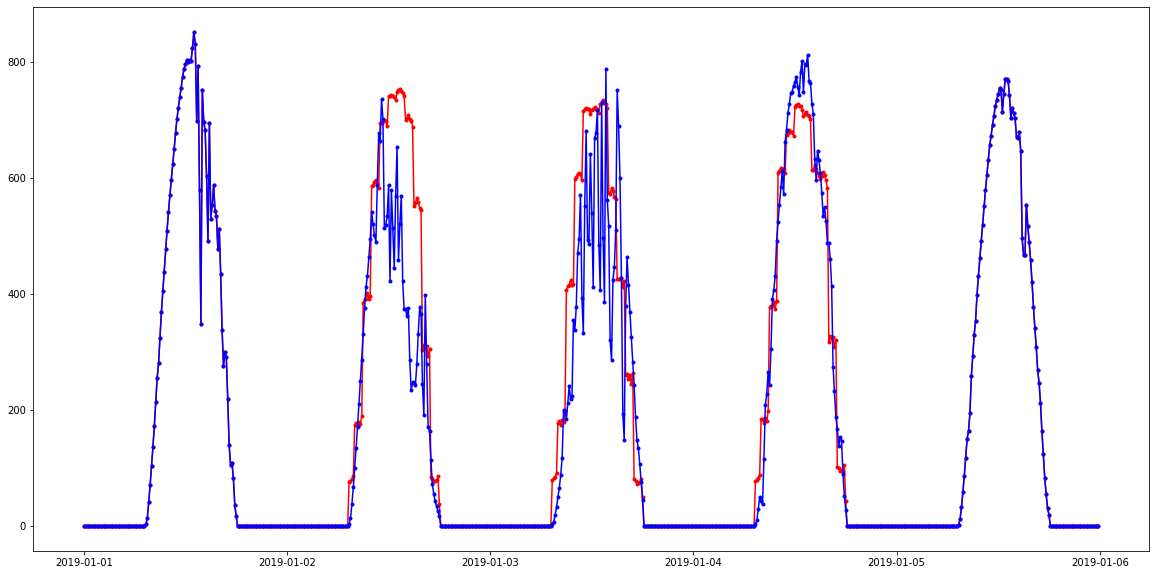

In [22]:
fecha1='2019-01-1'
fecha2='2019-01-05'
fig, ax=plt.subplots(figsize=(20,10))
ax.plot(impesoru.loc[fecha1:fecha2].Global,'r.-')
ax.plot(impesoru_target.Global.loc[fecha1:fecha2],'b.-')

In [308]:
    dfrad=impesoru_target.copy()
    dfrad['prediccion']=impesoru.Global.copy().astype(float)
    dfrad['minutodia']=(dfrad.index.hour*60)+dfrad.index.minute
    dfrad['me']=(dfrad.prediccion-dfrad.Global).astype(float)
    dfrad['mae']=np.abs(dfrad.Global-dfrad.prediccion).astype(float)
    dfmingroup=dfrad.groupby(['minutodia',pd.Grouper(freq='1H')]).mean()
    dfmindia=dfmingroup.groupby(pd.Grouper(level='minutodia',axis=0)).mean()

    dfmindia.loc[dfmindia.alturasolar<0,'mae']=np.nan
    meandiay=dfmindia.mae.mean()
    dfsamp2=dfrad.resample('D').sum()
    dfsamp=dfrad.resample('D').mean()
    dfsamp['dif_energia_wh']=dfsamp2['me']/6
    dfsamp['dif_energia_wh_mae']=dfsamp2['mae']/6
    dfsamp['energia_wh/m2']=dfsamp2['Global']/6
    dfsamp['porcentaje_mae']=(dfsamp['dif_energia_wh_mae']/dfsamp['energia_wh/m2'])*100
    dfsamp['energia_predicha_wh/m2']=dfsamp2['prediccion']/6
   # tablita=['Global','prediccion','energia_wh/m2','energia_predicha_wh/m2','dif_energia_wh','porcentaje_energia','porcentaje_mae','mae_de_día_promedio']
    tablita=['model','dif_energia_wh','porcentaje_energia','porcentaje_mae','mae_de_día_promedio']
    dfsamp3=dfsamp.resample('Y').mean()
    dfsamp3['mae_de_día_promedio']=meandiay
    dfsamp3['dif_energia_wh']=-dfsamp3['energia_wh/m2']+dfsamp3['energia_predicha_wh/m2']
    dfsamp3['porcentaje_energia']=dfsamp3['dif_energia_wh']/dfsamp3['energia_wh/m2']*100
    dfsamp3['model']=name_model

In [309]:
dfsamp3[tablita]

,model,dif_energia_wh,porcentaje_energia,porcentaje_mae,mae_de_día_promedio
tiempo,,,,,
2019-12-31,_new_train_seasonal_out_s_6_lr_0.01_in_s_6Glob...,-199.78001,-3.231668,18.02257,86.299737


-21.058225775625967


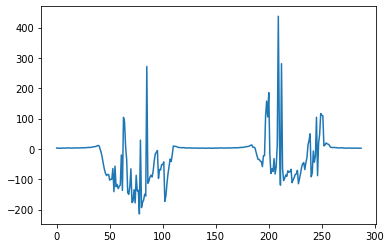

In [179]:
residuals=output-target
plt.plot(residuals)
print(residuals.mean())

In [2]:
residuals=output-target
plt.plot(residuals)
print(residuals.mean())

NameError: name 'output' is not defined